# Mesh Variables


Mesh variables are used to encode spatial data across the mesh. Underworld currently only provides mesh variables which store data on the mesh vertices (as opposed to mesh faces/edges/volumes). Mesh variables may be used for a number of purposes, but importantly they form the unknowns for the finite element numerical models you will be solving. 

Note that mesh variables may behave as spatially continuous objects through the finite element shape functions provided by the mesh. Interpolation is then provided through the following:
$$
    A(\mathbf{r}) = A_i\Phi_i(\mathbf{r})
$$



#### Overview:
1. Creating a mesh variable.
2. Setting initial conditons on mesh variables.
3. Gradients of mesh variable fields.
3. Loading and saving mesh variable data.
4. Remeshing data onto different mesh sizes.

**Keywords:** mesh variables, finite elements, load/save, initial conditions

In [1]:
import underworld as uw
import glucifer
import math

## Creating a MeshVariable

First create the mesh object upon which the mesh variable will be based:

In [2]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (4, 4), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.) )

Now add a variable to the mesh object, using `add_variable()` and specifying the `nodeDofCount` (dof, degree of freedom).

With `nodeDofCount=1` a scalar variable is defined at each node of the mesh eg, temperature field.

In [9]:
temperatureField = mesh.add_variable( nodeDofCount=1 )
type(temperatureField)

underworld.mesh._meshvariable.MeshVariable

## Set values on the MeshVariable

We may now set values on the mesh variable at each mesh vertex. The data is directly available as a Numpy array via the `data` handle on the `MeshVariable` object. Data may be accessed or modified using standard Numpy operations. For example, so set the value `273.15` at index `15`, you would write:

```
    temperatureField.data[15] = 273.15
```


**Example 1: Smooth function**

Initialise the temperature variable with a function based on its spatial coordinates
\\[
T = x \left( 1 - z \right)
\\]

In [4]:
for index, coord in enumerate(mesh.data):
    temperatureField.data[index] = coord[0] * (1.0 - coord[1])

Plot result


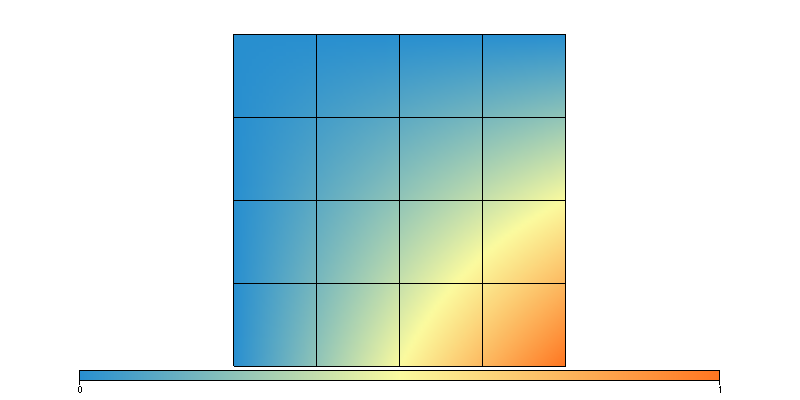

In [5]:
fig = glucifer.Figure(figsize=(800,400))
fig.append( glucifer.objects.Surface(mesh, temperatureField) )
fig.append( glucifer.objects.Mesh(mesh) )
fig.show()

## Vector valued MeshVariable

To describe for example a velocity, a vector mesh variable is required. Here we set the `nodeDofCount=dim` for dimensionality `dim`.

In [6]:
# create a two-dimensional velocity variable
velocityField = mesh.add_variable( nodeDofCount=2 )

Let's initialise the velocity field to the following:
$$
    \mathbf{v} = \sin(x \pi) \sin(y \pi) \left( z - z_{mid}, x - x_{mid} \right)
$$

where $mid$ denotes the middle of the domain.

In [7]:
coordmid = (0.5, 0.5)
for index, coord in enumerate(mesh.data):
    mag = math.sin( coord[0]*(math.pi) )*math.sin( coord[1]*(math.pi) )
    vx = -mag * (coord[1]-coordmid[1])
    vy =  mag * (coord[0]-coordmid[0])
    velocityField.data[index] = (vx, vy)
    temperatureField.data[index] = 1 - coord[1]


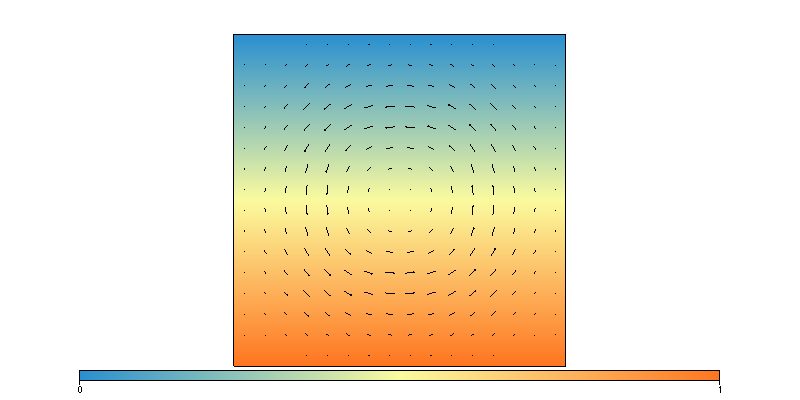

In [8]:
# visualise both the velocity and temperature
fig = glucifer.Figure(figsize=(800,400))
fig.append( glucifer.objects.Surface(mesh, temperatureField) )
fig.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.2, arrowHead=0.2) )
fig.show()

## Mesh variables gradients

The gradient of the field is accessible via the ``fn_gradient`` attribute:

In [9]:
gradTemp = temperatureField.fn_gradient

Gradients are calculated according to:

$$
    \nabla A(\mathbf{r}) = A_i\nabla\Phi_i(\mathbf{r})
$$
Note that gradients derived in this way are not generally continuous across element boundaries. 


As expected the vertical gradient of the temperature field $T = (1-z)$ is a constant. Note that we access the vertical gradient via the square bracket operator, with components ordered as:
$$
[ \frac{\partial T}{\partial x}, \frac{\partial T}{\partial y}, \frac{\partial T}{\partial z} ]
$$
or for a vector field:
$$
    [ \frac{\partial v_x}{\partial x}, \frac{\partial v_x}{\partial y}, \frac{\partial v_x}{\partial z},
      \frac{\partial v_y}{\partial x}, \frac{\partial v_y}{\partial y}, \frac{\partial v_y}{\partial z},
      \frac{\partial v_z}{\partial x}, \frac{\partial v_z}{\partial y}, \frac{\partial v_z}{\partial z} ]
$$


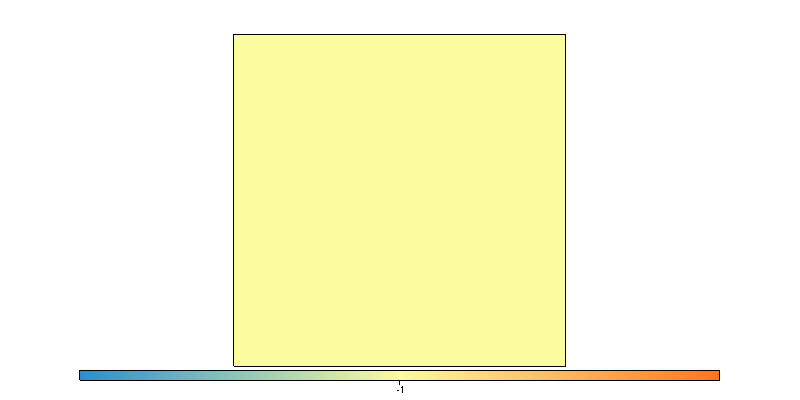

In [10]:
figGrad = glucifer.Figure(figsize=(800,400))
figGrad.append( glucifer.objects.Surface(mesh, gradTemp[1]) )
figGrad.show()

## Loading and saving variables

In this example we will use the set values for the temperature field, save them to file, reset them, and then recover the original data by loading from the file.

Underworld uses HDF5 for storing heaving data, leveraging the h5py tool for the writing and reading of these files.

In [11]:
# first save the existing variable 
temperatureField.save('MeshVariableSaveExample.h5')

In [12]:
# now create a new variable to load this data into
loadedVariable = mesh.add_variable(1)
# init to zero to be sure
loadedVariable.data[:] = 0.

In [13]:
# now load the data into the new variable
loadedVariable.load('MeshVariableSaveExample.h5')

In [14]:
# sanity check via Numpy array comparison
if not (temperatureField.data == loadedVariable.data).all():
    raise RuntimeError("The loaded variable does not correspond to the saved variable.")

In [15]:
# cleanup
if uw.rank()==0:
    import os;
    os.remove("MeshVariableSaveExample.h5")